# Libs


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import metrics
import pandas as pd
import numpy as np
import gc
# import optuna
# from optuna.samplers import TPESampler
from scipy import optimize
from scipy import special
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
train_full = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_train_ver2.pkl')

In [4]:
temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

# Funcs

In [5]:
from scipy import special

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)

    ll = np.empty_like(p)
    pos = y == 1
    ll[pos] = np.log(p[pos])
    ll[~pos] = np.log(1 - p[~pos])

    is_higher_better = False
    return 'logloss', -ll.mean(), is_higher_better

def logloss_init_score(y):
    p = y.mean()
    p = np.clip(p, 1e-15, 1 - 1e-15)  # never hurts
    log_odds = np.log(p / (1 - p))
    return log_odds

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better
    
def check_gradient(func, grad, values, eps=1e-8):
    approx = (func(values + eps) - func(values - eps)) / (2 * eps)
    return np.linalg.norm(approx - grad(values))

In [6]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [8]:
def cal_gini(model, data, features):
    pred = model.predict(data[features])
    auc = roc_auc_score(data['TARGET'], pred)
    gini = 2*auc - 1
    return gini 

# Base model

In [9]:
fl = FocalLoss(alpha=None, gamma=0)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver1 = lgb.train(
    params={'learning_rate': 0.018437, 
          'num_leaves': 58,
          'max_bin': 300,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':7, 
          'reg_alpha':3.564, 
          'reg_lambda':4.930, 
          'min_split_gain':0.143, 
          'min_child_weight':6, 'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=100,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 100 rounds
[100]	fit's focal_loss: 0.240566	val's focal_loss: 0.247814
[200]	fit's focal_loss: 0.229183	val's focal_loss: 0.241995
[300]	fit's focal_loss: 0.222166	val's focal_loss: 0.239702
[400]	fit's focal_loss: 0.216936	val's focal_loss: 0.23856
[500]	fit's focal_loss: 0.212392	val's focal_loss: 0.237832
[600]	fit's focal_loss: 0.208408	val's focal_loss: 0.237365
[700]	fit's focal_loss: 0.204653	val's focal_loss: 0.236993
[800]	fit's focal_loss: 0.201051	val's focal_loss: 0.236832
[900]	fit's focal_loss: 0.197724	val's focal_loss: 0.236662
[1000]	fit's focal_loss: 0.194512	val's focal_loss: 0.236554
[1100]	fit's focal_loss: 0.191406	val's focal_loss: 0.2365
[1200]	fit's focal_loss: 0.188388	val's focal_loss: 0.236473
[1300]	fit's focal_loss: 0.185308	val's focal_loss: 0.23641
[1400]	fit's focal_loss: 0.182472	val's focal_loss: 0.236366
[1500]	fit's focal_loss: 0.179602	val's focal_loss: 0.236372
Early stopping, best iteration is:
[

In [10]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.79813
Valid's ROC AUC: 0.79147


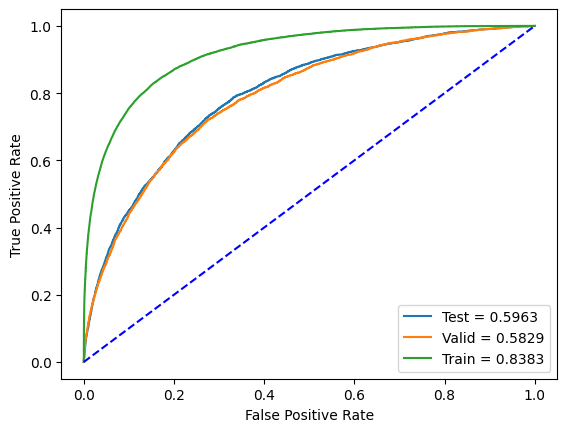

In [11]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [12]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver41_.csv', index = False)

# Ver 2

In [ ]:
fl = FocalLoss(alpha=None, gamma=0)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver2 = lgb.train(
    params={'learning_rate': 0.018437, 
          'num_leaves': 58,
          'max_bin': 300,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':7, 
          'reg_alpha':3.564, 
          'reg_lambda':4.930, 
          'min_split_gain':0.143, 
          'min_child_weight':6, 'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=200,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 200 rounds
[100]	fit's focal_loss: 0.239881	val's focal_loss: 0.241943
[200]	fit's focal_loss: 0.228592	val's focal_loss: 0.23607
[300]	fit's focal_loss: 0.221652	val's focal_loss: 0.233743
[400]	fit's focal_loss: 0.216251	val's focal_loss: 0.232417
[500]	fit's focal_loss: 0.211851	val's focal_loss: 0.231724
[600]	fit's focal_loss: 0.207816	val's focal_loss: 0.231211
[700]	fit's focal_loss: 0.204039	val's focal_loss: 0.230896
[800]	fit's focal_loss: 0.200366	val's focal_loss: 0.230617
[900]	fit's focal_loss: 0.196941	val's focal_loss: 0.230456
[1000]	fit's focal_loss: 0.193641	val's focal_loss: 0.230321
[1100]	fit's focal_loss: 0.190348	val's focal_loss: 0.230137
[1200]	fit's focal_loss: 0.187307	val's focal_loss: 0.230105
[1300]	fit's focal_loss: 0.184178	val's focal_loss: 0.230069
[1400]	fit's focal_loss: 0.1811	val's focal_loss: 0.230065
[1500]	fit's focal_loss: 0.178151	val's focal_loss: 0.230034
[1600]	fit's focal_loss: 0.175331	v

In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.78993
Valid's ROC AUC: 0.79187


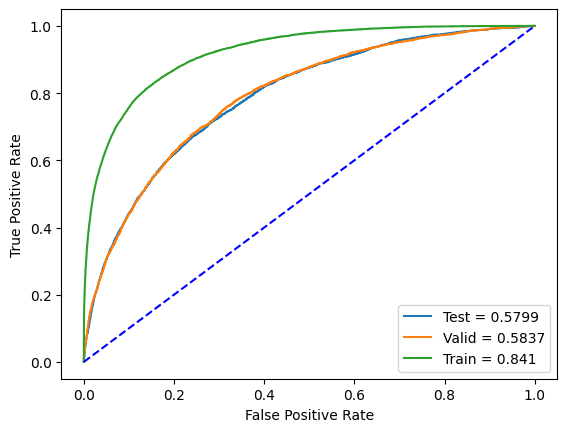

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver42.csv', index = False)

# Ver 3

In [ ]:
fl = FocalLoss(alpha=0.14288588039203828, gamma=0.002281401722878866)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver3 = lgb.train(
    params={'learning_rate': 0.020360476676599737, 
          'num_leaves': 64,
          'max_bin': 341,
          'colsample_bytree':0.15390329821664328, 
          'subsample':0.20331450075384144, 
          'max_depth':15, 
          'reg_alpha':2.5678055317901296, 
          'reg_lambda':5, 
          'min_split_gain':0.06538447791406805,
          'min_data_in_leaf': 633, 
          'min_child_weight':6, 'verbose': -1},
          # 'max_bin': 341, 'max_depth': 15, 'learning_rate': 0.020360476676599737, 'num_leaves': 64, 'colsample_bytree': 0.15390329821664328,
          #  'subsample': 0.20331450075384144, 'reg_alpha': 2.5678055317901296, 'reg_lambda': 5, 'min_split_gain': 0.06538447791406805, 
          #  'min_data_in_leaf': 633, 'alpha': 0.14288588039203828, 'gamma': 0.002281401722878866
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=100,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 100 rounds
[100]	fit's focal_loss: 0.0585567	val's focal_loss: 0.0576398
[200]	fit's focal_loss: 0.0540742	val's focal_loss: 0.0537266
[300]	fit's focal_loss: 0.052479	val's focal_loss: 0.0527455
[400]	fit's focal_loss: 0.0514646	val's focal_loss: 0.0523311
[500]	fit's focal_loss: 0.0506826	val's focal_loss: 0.0521172
[600]	fit's focal_loss: 0.0499873	val's focal_loss: 0.0519894
[700]	fit's focal_loss: 0.0493414	val's focal_loss: 0.0519066
[800]	fit's focal_loss: 0.0487441	val's focal_loss: 0.0518588
[900]	fit's focal_loss: 0.0481716	val's focal_loss: 0.0518252
[1000]	fit's focal_loss: 0.0476273	val's focal_loss: 0.0518047
[1100]	fit's focal_loss: 0.0471026	val's focal_loss: 0.0517919
[1200]	fit's focal_loss: 0.0465942	val's focal_loss: 0.0517767
[1300]	fit's focal_loss: 0.0461061	val's focal_loss: 0.0517753
Early stopping, best iteration is:
[1295]	fit's focal_loss: 0.0461304	val's focal_loss: 0.0517738


In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.78960
Valid's ROC AUC: 0.79195


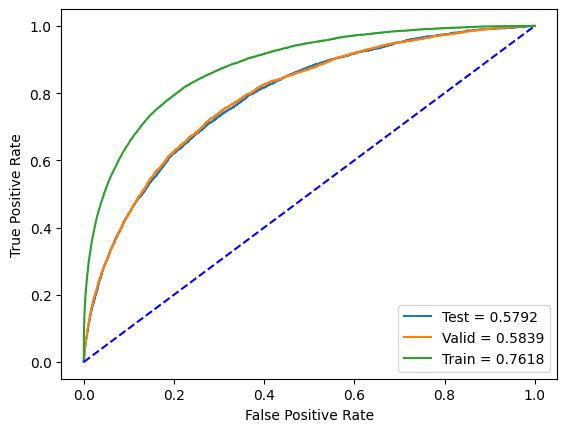

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver43.csv', index = False)

# Ver4

In [ ]:
fl = FocalLoss(alpha=0.14288588039203828, gamma=0.002281401722878866)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver4 = lgb.train(
    params={'learning_rate': 0.020360476676599737, 
          'num_leaves': 64,
          'max_bin': 341,
          'colsample_bytree':0.15390329821664328, 
          'subsample':0.20331450075384144, 
          'max_depth':15, 
          'reg_alpha':2.5678055317901296, 
          'reg_lambda':5, 
          'min_split_gain':0.06538447791406805,
          'min_data_in_leaf': 633,
          'verbose': -1},
          # 'max_bin': 341, 'max_depth': 15, 'learning_rate': 0.020360476676599737, 'num_leaves': 64, 'colsample_bytree': 0.15390329821664328,
          #  'subsample': 0.20331450075384144, 'reg_alpha': 2.5678055317901296, 'reg_lambda': 5, 'min_split_gain': 0.06538447791406805, 
          #  'min_data_in_leaf': 633, 'alpha': 0.14288588039203828, 'gamma': 0.002281401722878866
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=100,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 100 rounds
[100]	fit's focal_loss: 0.0585567	val's focal_loss: 0.0576398
[200]	fit's focal_loss: 0.0540742	val's focal_loss: 0.0537269
[300]	fit's focal_loss: 0.0524787	val's focal_loss: 0.0527397
[400]	fit's focal_loss: 0.0514582	val's focal_loss: 0.0523255
[500]	fit's focal_loss: 0.0506689	val's focal_loss: 0.052106
[600]	fit's focal_loss: 0.0499722	val's focal_loss: 0.0519747
[700]	fit's focal_loss: 0.0493274	val's focal_loss: 0.0518882
[800]	fit's focal_loss: 0.048728	val's focal_loss: 0.051838
[900]	fit's focal_loss: 0.0481533	val's focal_loss: 0.051808
[1000]	fit's focal_loss: 0.0476013	val's focal_loss: 0.0517909
[1100]	fit's focal_loss: 0.0470746	val's focal_loss: 0.0517843
[1200]	fit's focal_loss: 0.046572	val's focal_loss: 0.0517765
[1300]	fit's focal_loss: 0.04609	val's focal_loss: 0.0517703
[1400]	fit's focal_loss: 0.0456263	val's focal_loss: 0.0517673
Early stopping, best iteration is:
[1365]	fit's focal_loss: 0.0457828	va

In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.78944
Valid's ROC AUC: 0.79254


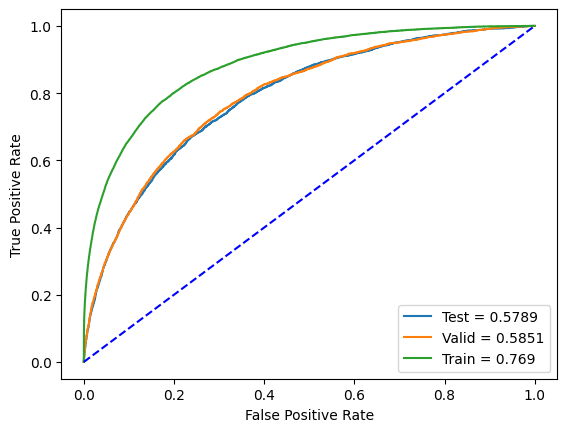

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver44.csv', index = False)

# Ver5

In [13]:
fl = FocalLoss(alpha=None, gamma=0)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver5 = lgb.train(
    params={'learning_rate': 0.018437, 
          'num_leaves': 58,
          'max_bin': 300,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':8, 
          'reg_alpha':3.564, 
          'reg_lambda':4.930, 
          'min_split_gain':0.143, 
          'min_child_weight':6, 'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=200,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 200 rounds
[100]	fit's focal_loss: 0.240179	val's focal_loss: 0.247747
[200]	fit's focal_loss: 0.228552	val's focal_loss: 0.241795
[300]	fit's focal_loss: 0.221303	val's focal_loss: 0.239632
[400]	fit's focal_loss: 0.215632	val's focal_loss: 0.238501
[500]	fit's focal_loss: 0.210712	val's focal_loss: 0.237705
[600]	fit's focal_loss: 0.206277	val's focal_loss: 0.237231
[700]	fit's focal_loss: 0.202075	val's focal_loss: 0.236863
[800]	fit's focal_loss: 0.198145	val's focal_loss: 0.236608
[900]	fit's focal_loss: 0.194439	val's focal_loss: 0.236464
[1000]	fit's focal_loss: 0.190933	val's focal_loss: 0.236362
[1100]	fit's focal_loss: 0.187544	val's focal_loss: 0.236296
[1200]	fit's focal_loss: 0.184229	val's focal_loss: 0.236266
[1300]	fit's focal_loss: 0.181083	val's focal_loss: 0.236233
[1400]	fit's focal_loss: 0.177994	val's focal_loss: 0.236193
[1500]	fit's focal_loss: 0.175094	val's focal_loss: 0.236181
[1600]	fit's focal_loss: 0.17214

In [14]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.79819
Valid's ROC AUC: 0.79183


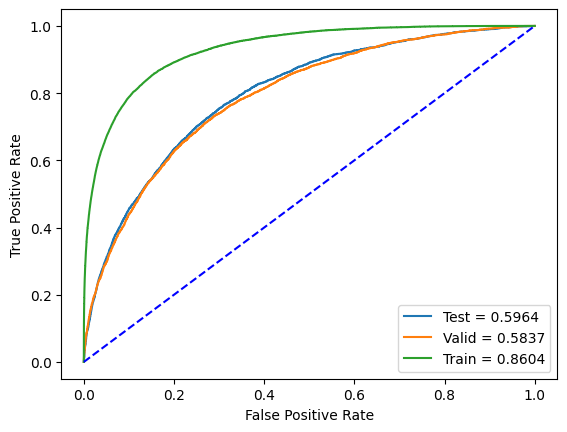

In [15]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver45.csv', index = False)

# Ver 6

In [ ]:
fl = FocalLoss(alpha=0.044937367654490065, gamma=0.12273738501498434)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver6 = lgb.train(
    params={'max_bin': 305, 
            'max_depth': 12, 
            'learning_rate': 0.09008722582584916, 
            'num_leaves': 70, 
            'colsample_bytree': 0.9560389034452258, 
            'subsample': 0.0301790851621473, 
            'reg_alpha': 2.6972649781753355, 
            'reg_lambda': 3, 
            'min_split_gain': 0.006388845306173709, 
            'min_child_weight': 7, 
            'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=200,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 200 rounds
[100]	fit's focal_loss: 0.0189906	val's focal_loss: 0.0189907
[200]	fit's focal_loss: 0.0183625	val's focal_loss: 0.0188584
[300]	fit's focal_loss: 0.0179714	val's focal_loss: 0.0188438
[400]	fit's focal_loss: 0.0178607	val's focal_loss: 0.0188433
Early stopping, best iteration is:
[281]	fit's focal_loss: 0.0180325	val's focal_loss: 0.0188399


In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.78627
Valid's ROC AUC: 0.78793


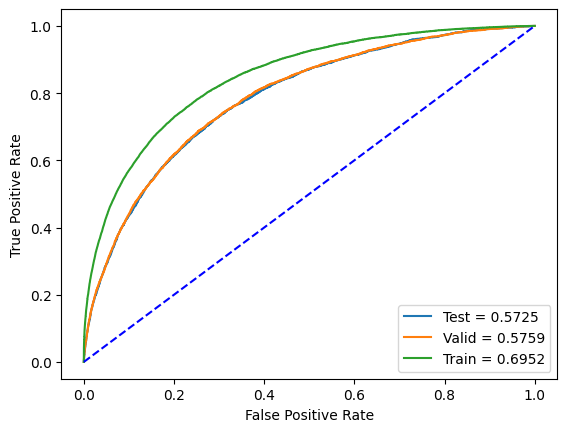

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver6.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver46.csv', index = False)

# Ver 7

In [ ]:
fl = FocalLoss(alpha=0.38779878570874593, gamma=0.02019357833342426)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver7 = lgb.train(
    params={'max_bin': 272, 
            'max_depth': 10, 
            'learning_rate': 0.03367920207396604, 
            'num_leaves': 78, 
            'colsample_bytree': 0.4276833691505903, 
            'subsample': 0.10781371350669815, 
            'reg_alpha': 3.4068120998415794, 
            'reg_lambda': 5, 
            'min_split_gain': 0.002330925838019653, 
            'min_child_weight': 8, 
            'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=200,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 200 rounds
[100]	fit's focal_loss: 0.100418	val's focal_loss: 0.103125
[200]	fit's focal_loss: 0.0946383	val's focal_loss: 0.10141
[300]	fit's focal_loss: 0.0905679	val's focal_loss: 0.100908
[400]	fit's focal_loss: 0.0871058	val's focal_loss: 0.100678
[500]	fit's focal_loss: 0.0839207	val's focal_loss: 0.100621
[600]	fit's focal_loss: 0.0809322	val's focal_loss: 0.10053
[700]	fit's focal_loss: 0.0782164	val's focal_loss: 0.100531
[800]	fit's focal_loss: 0.0755679	val's focal_loss: 0.100509
[900]	fit's focal_loss: 0.0730938	val's focal_loss: 0.100501
[1000]	fit's focal_loss: 0.0706738	val's focal_loss: 0.10059
Early stopping, best iteration is:
[883]	fit's focal_loss: 0.07351	val's focal_loss: 0.100492


In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.78822
Valid's ROC AUC: 0.79120


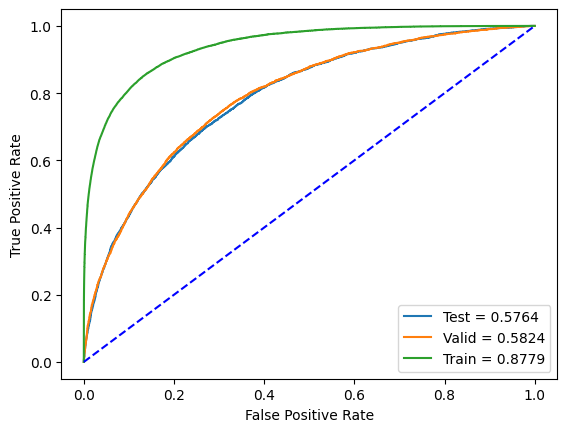

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver7.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver47.csv', index = False)

# Concat

In [ ]:
lst1 = [1,1]
lst2 = [2,2]
lst3 = [3,3]
[(lst1[idx] + lst2[idx] + lst3[idx])/ 3 for idx in range(len(lst1))]

[2.0, 2.0]

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_ver1 = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
pred_ver2 = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
pred_ver5 = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
pred_kaggle = [(pred_ver1[idx] + pred_ver2[idx] + pred_ver5[idx])/3 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat.csv', index = False)

# Ver 8

In [17]:
fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 300, 
     'max_depth': 12, 
     'learning_rate': 0.034348802349598966,
     'num_leaves': 16, 
     'lambda_l2': 4.839736625515825e-05, 
     'lambda_l1': 0.011784631017575379, 
     'min_gain_to_split': 6.7019518271194505e-06, 
     'min_data_in_leaf': 3124, 
     'feature_fraction': 0.2510984803589828, 
     'min_sum_hessian_in_leaf': 3.8925793495459575
}

model_ver8 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.104670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108911
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 505
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00891519	val's focal_loss: 0.00908045
[200]	fit's focal_loss: 0.0086077	val's focal_loss: 0.00887361
[300]	fit's focal_loss: 0.0084498	val's focal_loss: 0.00880519
[400]	fit's focal_loss: 0.00833443	val's focal_loss: 0.00876935
[500]	fit's focal_loss: 0.00823909	val's focal_loss: 0.00874984
[600]	fit's focal_loss: 0.00815276	val's focal_loss: 0.00873708
[700]	fit's focal_loss: 0.00807529	val's focal_loss: 0.00872938
[Lig

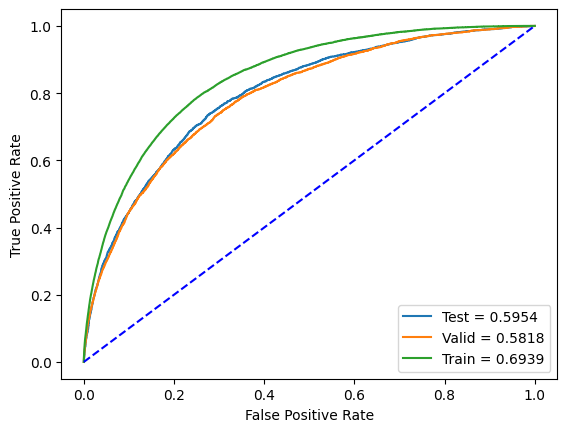

In [18]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver8.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver8.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver8.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

# Concat2

In [20]:
## Ver1 , ver 8
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_ver1 = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
pred_ver8 = special.expit(fl.init_score(train['TARGET']) + model_ver8.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
pred_kaggle = [(pred_ver1[idx] + pred_ver8[idx])/2 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat2.csv', index = False)

# Concat 3

In [21]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx] + pred_concat[idx])/3 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat3.csv', index = False)

# Concat 4

In [22]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')

pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx]*2 + pred_concat[idx])/4 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat4.csv', index = False)

# Concat 5

In [23]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')

pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx]*3 + pred_concat[idx])/5 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat5.csv', index = False)

# Concat 6

In [24]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')

pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx]*5 + pred_concat[idx])/7 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat6.csv', index = False)

# Concat 7

In [25]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')

pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx]*4 + pred_concat[idx])/5 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat7.csv', index = False)

# Concat 8 

In [26]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')

pred_45 = pd.read_csv('/content/submission_focallloss_ver45.csv')['TARGET']
pred_41 = pd.read_csv('/content/submission_focallloss_ver41.csv')['TARGET']
pred_concat = pd.read_csv('/content/submission_focallloss_ver_concat.csv')['TARGET']
pred_concat5= pd.read_csv('/content/submission_focallloss_ver_concat5.csv')['TARGET']

pred_kaggle = [(pred_45[idx] + pred_41[idx]*3 + pred_concat[idx] + pred_concat5[idx]*3)/8 for idx in range(len(pred_ver1))]
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_concat8.csv', index = False)